# Predict a binary value using BlazingText

## BlazingText

https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html

# Prepare the Environment

## Upgrade the version of boto3 and sagemaker

In [1]:
%pip install -qU --upgrade boto3
%pip install -qU --upgrade sagemaker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import sagemaker
from sagemaker.estimator import Estimator 
from sagemaker import get_execution_role
import boto3
from sagemaker import image_uris
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
import time
from time import gmtime, strftime

## Download the NTLK Trained Models

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download the NTLK Stopwords list

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Setup your your Environment Variables

In [5]:
role = get_execution_role()
sess = sagemaker.Session() 
region = sess.boto_session.region_name
bucket = sess.default_bucket()
print("The role is ", role)
print("The session is ", sess)
print("The region is ", region)
print("The bucket is ", bucket)

The role is  arn:aws:iam::870427325799:role/LabRole
The session is  <sagemaker.session.Session object at 0x7f4f9a515510>
The region is  us-east-1
The bucket is  sagemaker-us-east-1-870427325799


## We are going to use BlazingText to make predicitons based on the SMS Spam Collection Dataset

## SMS Spam Collection Dataset
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

### About Dataset

#### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

#### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

-> A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link].

-> A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link].

-> A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link].

-> Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link]. This corpus has been used in the following academic researches:


# Prepare and Inspect the Data
## Download the Dataset to Jupyter Notebook and Explore the Data

In [6]:
# Import the data into a pandas DataFrame

spam_data = pd.read_csv("spam.csv")

In [7]:
# Look at the data

spam_data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ?_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
# Lets check to see if there are any missing values

spam_data.isnull().sum()

Category    0
Message     0
dtype: int64

In [9]:
# Use describe to get some information about the data

spam_data.describe()

,Category,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
# Use the group by to see how many records there are for each label

spam_data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

<AxesSubplot: xlabel='Category', ylabel='count'>

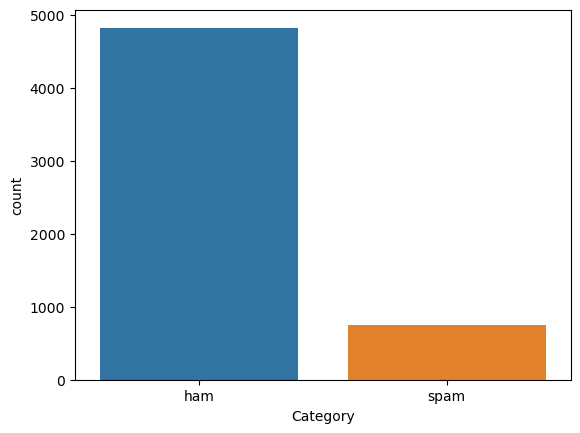

In [11]:
# Using Seaborn visualize the balance between the two labels

sns.countplot(x ='Category', data = spam_data)

In [12]:
# I am creating a copy of the Dataframe so that I can modify it for deeper visualization

spam_data_analysis = spam_data.copy()

In [13]:
# Make sure the copy worked

spam_data_analysis

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ?_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [14]:
# Create a new column call Message_Length and sore the length of each corresponding message 

spam_data_analysis['Message_Length'] = spam_data_analysis.Message.apply(len)
spam_data_analysis.head()

,Category,Message,Message_Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Text(0.5, 0, 'Message Length')

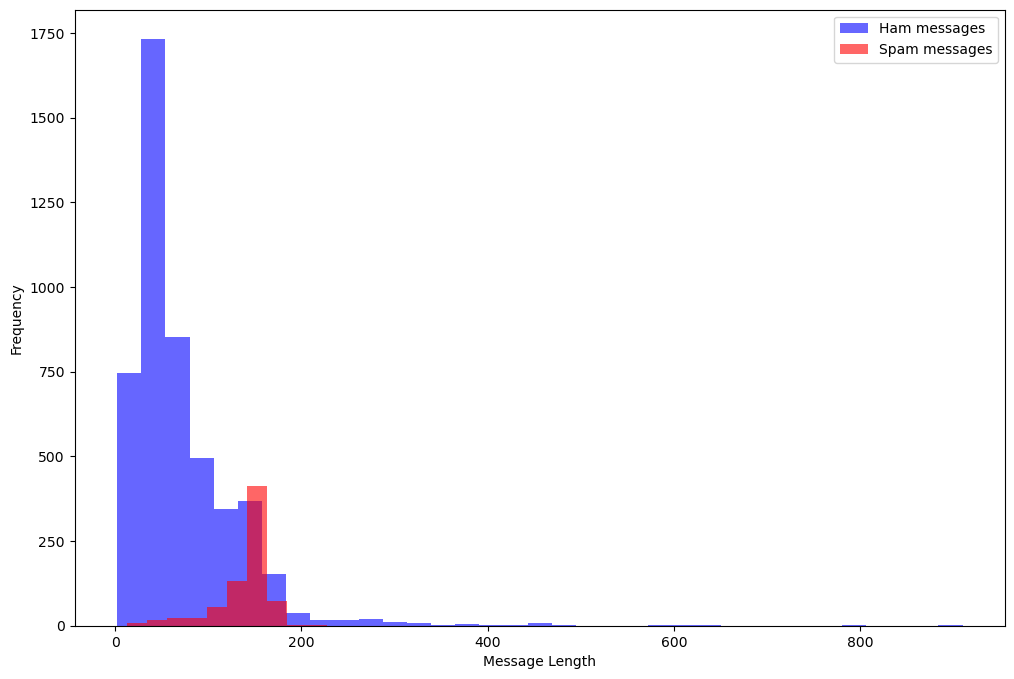

In [15]:
# Plot the relationship between length of the message and category

plt.figure(figsize=(12, 8))

spam_data_analysis[spam_data_analysis.Category=='ham'].Message_Length.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
spam_data_analysis[spam_data_analysis.Category=='spam'].Message_Length.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

# Transform the Data into the following format

__label__4  linux ready for prime time , intel says , despite all the linux hype , the open-source movement has yet to make a huge splash in the desktop market . that may be about to change , thanks to chipmaking giant intel corp .

__label__2  bowled by the slower one again , kolkata , november 14 the past caught up with sourav ganguly as the indian skippers return to international cricket was short lived .


In [16]:
# Concatenate __label__ with spam_data['Category'] 

spam_data['Category'] = "__label__" + spam_data['Category']

In [17]:
# Look at the change

spam_data

,Category,Message
0,__label__ham,"Go until jurong point, crazy.. Available only ..."
1,__label__ham,Ok lar... Joking wif u oni...
2,__label__spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,__label__ham,U dun say so early hor... U c already then say...
4,__label__ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,__label__spam,This is the 2nd time we have tried 2 contact u...
5568,__label__ham,Will ?_ b going to esplanade fr home?
5569,__label__ham,"Pity, * was in mood for that. So...any other s..."
5570,__label__ham,The guy did some bitching but I acted like i'd...


In [18]:
# Use NTLK word_tokenize to seperate the sentence into words

spam_data['Message'] = spam_data['Message'].apply(word_tokenize)

In [19]:
# Inspect the results

print(spam_data)

           Category                                            Message
0      __label__ham  [Go, until, jurong, point, ,, crazy, .., Avail...
1      __label__ham           [Ok, lar, ..., Joking, wif, u, oni, ...]
2     __label__spam  [Free, entry, in, 2, a, wkly, comp, to, win, F...
3      __label__ham  [U, dun, say, so, early, hor, ..., U, c, alrea...
4      __label__ham  [Nah, I, do, n't, think, he, goes, to, usf, ,,...
...             ...                                                ...
5567  __label__spam  [This, is, the, 2nd, time, we, have, tried, 2,...
5568   __label__ham  [Will, ?, _, b, going, to, esplanade, fr, home...
5569   __label__ham  [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570   __label__ham  [The, guy, did, some, bitching, but, I, acted,...
5571   __label__ham                [Rofl, ., Its, true, to, its, name]

[5572 rows x 2 columns]


In [20]:
# The results create a list in the message column and we will use apply, join and lanbda to replace the list with a string

spam_data['Message'] = spam_data['Message'].apply(lambda x: ' '.join(x))

In [21]:
spam_data

,Category,Message
0,__label__ham,"Go until jurong point , crazy .. Available onl..."
1,__label__ham,Ok lar ... Joking wif u oni ...
2,__label__spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,__label__ham,U dun say so early hor ... U c already then sa...
4,__label__ham,"Nah I do n't think he goes to usf , he lives a..."
...,...,...
5567,__label__spam,This is the 2nd time we have tried 2 contact u...
5568,__label__ham,Will ? _ b going to esplanade fr home ?
5569,__label__ham,"Pity , * was in mood for that . So ... any oth..."
5570,__label__ham,The guy did some bitching but I acted like i '...


In [22]:
# Print out the list of stopwords that will be removed from messages

stopwords = stopwords.words('english')

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
# Let's add a few of our own words

new_words=('nah','wif', 'dun')
for i in new_words:
    stopwords.append(i)
print(stopwords)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
# We will convert the case of each word to lower case to simplify the removal. ie: The, THE and the all equal the

spam_data['Message'] = spam_data['Message'].str.lower()

In [25]:
spam_data

,Category,Message
0,__label__ham,"go until jurong point , crazy .. available onl..."
1,__label__ham,ok lar ... joking wif u oni ...
2,__label__spam,free entry in 2 a wkly comp to win fa cup fina...
3,__label__ham,u dun say so early hor ... u c already then sa...
4,__label__ham,"nah i do n't think he goes to usf , he lives a..."
...,...,...
5567,__label__spam,this is the 2nd time we have tried 2 contact u...
5568,__label__ham,will ? _ b going to esplanade fr home ?
5569,__label__ham,"pity , * was in mood for that . so ... any oth..."
5570,__label__ham,the guy did some bitching but i acted like i '...


In [26]:
# Using Apply, lambda and a For loop remove all the stop words
# word for word in x.split() - Split the first message into words and run the loop for each word
# if the word is not in teh stopword list use the join method to put it back in the sentence

spam_data['Message'] = spam_data['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [27]:
spam_data

,Category,Message
0,__label__ham,"go jurong point , crazy .. available bugis n g..."
1,__label__ham,ok lar ... joking u oni ...
2,__label__spam,free entry 2 wkly comp win fa cup final tkts 2...
3,__label__ham,u say early hor ... u c already say ...
4,__label__ham,"n't think goes usf , lives around though"
...,...,...
5567,__label__spam,2nd time tried 2 contact u. u â€ å “ 750 pound...
5568,__label__ham,? _ b going esplanade fr home ?
5569,__label__ham,"pity , * mood . ... suggestions ?"
5570,__label__ham,guy bitching acted like 'd interested buying s...


In [28]:
# Shuffle and Split the data into 80% training and 20% validating

train_data, validate_data = train_test_split(spam_data, test_size=0.2)

# Convert dataframes to TEXT files and save them locally to the notebook and make sure to exclude the headers so that BlazingText will accept the file

train_data.to_csv('spam_data.train', sep=' ', header=False, index=False, quotechar=" ")
validate_data.to_csv('spam_data.validate', sep=' ', header=False, index=False, quotechar=" ")

In [29]:
# Inspect the shape of the training data

train_data.shape

(4457, 2)

In [30]:
# Inspect the shape of the validation data

validate_data.shape

(1115, 2)

In [31]:
# Copy the file to your S3 bucket using sess.upload_data
# You will need to pass the file to be uploaded, a prefix (top level folder to store the data) and the subfolders
# Here we will also define the output folder for the results
# Note I did not call them .csv because the are not csv files but text files

prefix = 'spam'
training_data_path = sess.upload_data( path='spam_data.train', key_prefix=prefix + '/input/train') 
validation_data_path = sess.upload_data( path='spam_data.validate', key_prefix=prefix + '/input/validate')
output_data_path = 's3://{}/{}/output'.format(bucket, prefix)
print(training_data_path)
print(validation_data_path)
print(output_data_path)

s3://sagemaker-us-east-1-870427325799/spam/input/train/spam_data.train
s3://sagemaker-us-east-1-870427325799/spam/input/validate/spam_data.validate
s3://sagemaker-us-east-1-870427325799/spam/output


In [32]:
# Create the training container

container = image_uris.retrieve(framework='blazingtext',region=region)

In [33]:
# Create your data channels

train_data = sagemaker.inputs.TrainingInput(
    training_data_path,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validate_data = sagemaker.inputs.TrainingInput(
    validation_data_path,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validate_data}

In [34]:
# Here we are using the only required hyperameter and everything else will be set to default

bt_model = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=output_data_path,
    hyperparameters={
        "mode": "supervised"
    },
)

In [35]:
# Train the model

bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2023-02-27-14-51-01-000


2023-02-27 14:51:01 Starting - Starting the training job...
2023-02-27 14:51:16 Starting - Preparing the instances for training......
2023-02-27 14:52:12 Downloading - Downloading input data...
2023-02-27 14:53:02 Training - Training image download completed. Training in progress...Arguments: train
[02/27/2023 14:53:06 WARNING 140164468479808] Loggers have already been setup.
[02/27/2023 14:53:06 WARNING 140164468479808] Loggers have already been setup.
[02/27/2023 14:53:06 INFO 140164468479808] nvidia-smi took: 0.02518939971923828 secs to identify 0 gpus
[02/27/2023 14:53:06 INFO 140164468479808] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[02/27/2023 14:53:06 INFO 140164468479808] Processing /opt/ml/input/data/train/spam_data.train . File size: 0.3796567916870117 MB
[02/27/2023 14:53:06 INFO 140164468479808] Processing /opt/ml/input/data/validation/spam_data.validate . File size: 0.09500980377197266 MB
Read 0M w

# Deploy the model (no tuning)
## Here we are going to deploy the model so that we can make some inferences

In [36]:
# Retrieve model data from training job

training_job_model_data = bt_model.model_data
training_job_model_data

's3://sagemaker-us-east-1-870427325799/spam/output/blazingtext-2023-02-27-14-51-01-000/output/model.tar.gz'

In [37]:
# Create a unique model name so it won't overwrite ones taht are already there using date and time

deployed_BlazingText_model_name = "spam-bt-model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name is " + deployed_BlazingText_model_name)

Model name is spam-bt-model2023-02-27-15-09-30


In [38]:
# Container Definition https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ContainerDefinition.html

client = boto3.client(service_name="sagemaker")

create_model_response = client.create_model(
    ModelName=deployed_BlazingText_model_name,
    Containers=[
        {
            "Image": container, # use the same container defined in the estimator
            "ModelDataUrl": training_job_model_data
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Model Arn: arn:aws:sagemaker:us-east-1:870427325799:model/spam-bt-model2023-02-27-15-09-30


In [39]:
# Create the endpoint configuration

spam_epc_name = "blazingtext-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=spam_epc_name,
    ProductionVariants=[
        {
            "VariantName": "btVariant",
            "ModelName": deployed_BlazingText_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:870427325799:endpoint-config/blazingtext-serverless-epc2023-02-27-15-09-32


In [40]:
# Create the endpoint response

spam_ep_name = "spam-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=spam_ep_name,
    EndpointConfigName=spam_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:870427325799:endpoint/spam-serverless-ep2023-02-27-15-09-36


In [41]:
# Wait for endpoint to reach a terminal state (InService) using describe endpoint

describe_endpoint_response = client.describe_endpoint(EndpointName=spam_ep_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=spam_ep_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'spam-serverless-ep2023-02-27-15-09-36',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:870427325799:endpoint/spam-serverless-ep2023-02-27-15-09-36',
 'EndpointConfigName': 'blazingtext-serverless-epc2023-02-27-15-09-32',
 'ProductionVariants': [{'VariantName': 'btVariant',
   'DeployedImages': [{'SpecifiedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1',
     'ResolvedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext@sha256:0574bac80b6081e684481c1325d7c5ab0111fb28be306f9e66b0508297736b7a',
     'ResolutionTime': datetime.datetime(2023, 2, 27, 15, 9, 37, 13000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 2, 27, 15, 9, 36, 421000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 2, 27, 15, 11, 19, 878000, tzinfo=tzlo

In [80]:
# Test the model by supplying two know sentences in the training file

sentences = [
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
    "WINNER!! As a valued network customer you have been selected to receivea â€ Å“900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
]

# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [" ".join(nltk.word_tokenize(sent)) for sent in sentences]
tokenized_sentences = [x.lower() for x in tokenized_sentences]

runtime = boto3.Session().client('sagemaker-runtime')

payload = {"instances": tokenized_sentences}

response = runtime.invoke_endpoint(
    EndpointName=spam_ep_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)

output = json.loads(response['Body'].read().decode('utf-8'))

print(output)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


[{'label': ['__label__ham'], 'prob': [0.7290090918540955]}, {'label': ['__label__spam'], 'prob': [0.8990699052810669]}]


In [ ]:
# Delete the endpoint

client.delete_model(ModelName=deployed_BlazingText_model_name)
client.delete_endpoint_config(EndpointConfigName=spam_epc_name)
client.delete_endpoint(EndpointName=spam_ep_name)

## Hyperparameter Tuning

In [81]:
# Set the blazingtext hyperparameters
# tunable hyperparameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html

bt_model.set_hyperparameters()

In [82]:
# The BlazingText Text Classification algorithm (supervised mode), also reports on a single metric during training: the validation:accuracy.

from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hypertuner = HyperparameterTuner(bt_model, 
                                 objective_metric_name = 'validation:accuracy',
                                 hyperparameter_ranges = {
                                 'epochs' : CategoricalParameter([1,3,5]),
                                 'min_count' : CategoricalParameter([1,3,5]),
                                 'learning_rate' : ContinuousParameter(0.01, 0.1),
                                 'batch_size': CategoricalParameter([32,64,128,256,512])},   
                                 objective_type = 'Maximize',
                                 metric_definitions = [{'Name': 'validation:accuracy', 'Regex': 'loss (\S+)'}],
                                 max_jobs=10, 
                                 max_parallel_jobs=1
                                )


In [ ]:
# Start the training and tuning

hypertuner.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating hyperparameter tuning job with name: blazingtext-230227-1550


........................................................................................................................................................................................................................

In [ ]:
# Print out the best parameters the tuning job found

print("Best hyerparameter tuning job:{}".format(hypertuner.best_training_job()))
print("Best parameters found={}".format(hypertuner.best_estimator().hyperparameters()))

In [87]:
# Confirgure the model with the parameters that were printed

bt_model = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=output_data_path,
    hyperparameters={
        "mode": "supervised",
        "batch_size": 32,
        "epochs": 5,
        "learning_rate": 0.08928775025027585,
        "min_count": 1
    },
)

In [ ]:
# Train the model

bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2023-02-27-16-23-32-729


2023-02-27 16:23:33 Starting - Starting the training job...
2023-02-27 16:23:49 Starting - Preparing the instances for training......
2023-02-27 16:24:39 Downloading - Downloading input data...
2023-02-27 16:25:30 Training - Training image download completed. Training in progress..Arguments: train
[02/27/2023 16:25:35 WARNING 140513712944960] Loggers have already been setup.
[02/27/2023 16:25:35 WARNING 140513712944960] Loggers have already been setup.
[02/27/2023 16:25:35 INFO 140513712944960] nvidia-smi took: 0.025223970413208008 secs to identify 0 gpus
[02/27/2023 16:25:35 INFO 140513712944960] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[02/27/2023 16:25:35 INFO 140513712944960] Processing /opt/ml/input/data/train/spam_data.train . File size: 0.3796567916870117 MB
[02/27/2023 16:25:35 INFO 140513712944960] Processing /opt/ml/input/data/validation/spam_data.validate . File size: 0.09500980377197266 MB
Read 0M w

# Deploy the model (with tuning)
## Here we are going to deploy the model so that we can make some inferences

In [ ]:
# Retrieve model data from training job

training_job_model_data = bt_model.model_data
training_job_model_data

In [ ]:
# Create a unique model name so it won't overwrite ones taht are already there using date and time
deployed_BlazingText_model_name = "spam-bt-model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name is " + deployed_BlazingText_model_name)

In [ ]:
# Container Definition https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ContainerDefinition.html

client = boto3.client(service_name="sagemaker")

create_model_response = client.create_model(
    ModelName=deployed_BlazingText_model_name,
    Containers=[
        {
            "Image": container, # use the same container defined in the estimator
            "ModelDataUrl": training_job_model_data
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

In [ ]:
spam_epc_name = "blazingtext-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=spam_epc_name,
    ProductionVariants=[
        {
            "VariantName": "btVariant",
            "ModelName": deployed_BlazingText_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

In [ ]:
spam_ep_name = "spam-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=spam_ep_name,
    EndpointConfigName=spam_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

In [ ]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint

import time

describe_endpoint_response = client.describe_endpoint(EndpointName=spam_ep_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=spam_ep_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

In [ ]:
# Test the model by supplying two know sentences in the training file

sentences = [
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
    "WINNER!! As a valued network customer you have been selected to receivea â€ Å“900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
]

# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [" ".join(nltk.word_tokenize(sent)) for sent in sentences]
tokenized_sentences = [x.lower() for x in tokenized_sentences]

runtime = boto3.Session().client('sagemaker-runtime')

payload = {"instances": tokenized_sentences}

response = runtime.invoke_endpoint(
    EndpointName=spam_ep_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)

output = json.loads(response['Body'].read().decode('utf-8'))

print(output)

In [ ]:
# Delete the endpoint

client.delete_model(ModelName=deployed_BlazingText_model_name)
client.delete_endpoint_config(EndpointConfigName=spam_epc_name)
client.delete_endpoint(EndpointName=spam_ep_name)